Convolutional Dictionary Learning with Spatial Mask
===================================================

This example demonstrates the use of [cbpdndl.ConvBPDNMaskDcplDictLearn](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdndl.html#sporco.admm.cbpdndl.ConvBPDNMaskDcplDictLearn) for convolutional dictionary learning with a spatial mask, from a set of colour training images [[30]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2016-convolutional). The dictionary learning algorithm is based on the hybrid mask decoupling / ADMM consensus dictionary update [[15]](http://sporco.rtfd.org/en/latest/zreferences.html#garcia-2017-convolutional).

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco.admm import tvl2
from sporco.admm import cbpdndl
from sporco import util
from sporco import plot
plot.config_notebook_plotting()

Load training images.

In [2]:
exim = util.ExampleImages(scaled=True, zoom=0.25)
S1 = exim.image('barbara.png', idxexp=np.s_[10:522, 100:612])
S2 = exim.image('kodim23.png', idxexp=np.s_[:, 60:572])
S = np.stack((S1, S2), axis=3)

Construct initial dictionary.

In [3]:
np.random.seed(12345)
D0 = np.random.randn(8, 8, 3, 32)

Create random mask and apply to training images.

In [4]:
frc = 0.5
W = util.rndmask(S.shape[0:3] + (1,), frc, dtype=np.float32)
Sw = W * S

$\ell_2$-TV denoising with a spatial mask as a non-linear lowpass filter.

In [5]:
lmbda = 0.1
opt = tvl2.TVL2Denoise.Options({'Verbose': False, 'MaxMainIter': 200,
            'DFidWeight': W, 'gEvalY': False, 'AutoRho': {'Enabled': True}})
b = tvl2.TVL2Denoise(Sw, lmbda, opt, caxis=2)
sl = b.solve()
sh = Sw - sl

CDL without a spatial mask using [admm.cbpdndl.ConvBPDNDictLearn](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdndl.html#sporco.admm.cbpdndl.ConvBPDNDictLearn). (Note that [parcnsdl.ConvBPDNMaskDcplDictLearn_Consensus](http://sporco.rtfd.org/en/latest/sporco.admm.parcnsdl.html#sporco.admm.parcnsdl.ConvBPDNMaskDcplDictLearn_Consensus) solves the same problem, but is substantially faster on a multi-core architecture.)

In [6]:
lmbda = 0.05
opt1 = cbpdndl.ConvBPDNDictLearn.Options({'Verbose': True,
            'MaxMainIter': 200, 'AccurateDFid': True,
            'CBPDN': {'rho': 50.0*lmbda + 0.5},
            'CCMOD': {'rho': 3e2}})
d1 = cbpdndl.ConvBPDNDictLearn(D0, sh, lmbda, opt1)
D1 = d1.solve()

Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D       
--------------------------------------------------------------------------------------------------------


   0  1.25e+03  1.27e+02  2.24e+04  7.35e-07  3.31e-01  2.40e+00  3.00e+00  4.31e-02  2.30e-01  3.00e+02


   1  1.12e+03  1.53e+02  1.93e+04  7.52e-07  1.67e-01  7.28e-01  3.00e+00  5.11e-02  3.36e-01  3.00e+02


   2  1.03e+03  7.68e+01  1.90e+04  7.19e-07  1.25e-01  5.48e-01  3.00e+00  3.15e-02  2.75e-01  3.00e+02


   3  9.73e+02  5.52e+01  1.84e+04  7.43e-07  9.77e-02  4.53e-01  3.00e+00  2.31e-02  2.18e-01  3.00e+02


   4  9.36e+02  6.36e+01  1.74e+04  6.83e-07  7.85e-02  3.87e-01  3.00e+00  1.95e-02  1.93e-01  3.00e+02


   5  9.04e+02  4.99e+01  1.71e+04  9.79e-07  6.36e-02  3.38e-01  3.00e+00  1.55e-02  1.76e-01  3.00e+02


   6  8.78e+02  4.73e+01  1.66e+04  7.63e-07  5.33e-02  3.09e-01  3.00e+00  1.31e-02  1.53e-01  3.00e+02


   7  8.56e+02  4.75e+01  1.62e+04  7.65e-07  4.51e-02  2.81e-01  3.00e+00  1.12e-02  1.35e-01  3.00e+02


   8  8.38e+02  4.53e+01  1.59e+04  7.78e-07  3.83e-02  2.56e-01  3.00e+00  9.59e-03  1.22e-01  3.00e+02


   9  8.23e+02  4.36e+01  1.56e+04  6.67e-07  3.30e-02  2.36e-01  3.00e+00  8.35e-03  1.11e-01  3.00e+02


  10  8.09e+02  4.30e+01  1.53e+04  6.81e-07  2.87e-02  2.19e-01  3.00e+00  7.40e-03  1.01e-01  3.00e+02


  11  7.98e+02  4.24e+01  1.51e+04  8.52e-07  2.52e-02  2.04e-01  3.00e+00  6.61e-03  9.29e-02  3.00e+02


  12  7.89e+02  4.18e+01  1.49e+04  9.43e-07  2.24e-02  1.90e-01  3.00e+00  5.97e-03  8.62e-02  3.00e+02


  13  7.80e+02  4.13e+01  1.48e+04  6.59e-07  2.00e-02  1.78e-01  3.00e+00  5.44e-03  8.03e-02  3.00e+02


  14  7.73e+02  4.07e+01  1.46e+04  6.18e-07  1.81e-02  1.67e-01  3.00e+00  5.00e-03  7.53e-02  3.00e+02


  15  7.66e+02  4.03e+01  1.45e+04  1.03e-06  1.64e-02  1.57e-01  3.00e+00  4.64e-03  7.10e-02  3.00e+02


  16  7.60e+02  3.99e+01  1.44e+04  7.56e-07  1.51e-02  1.49e-01  3.00e+00  4.34e-03  6.73e-02  3.00e+02


  17  7.55e+02  3.95e+01  1.43e+04  7.94e-07  1.39e-02  1.41e-01  3.00e+00  4.09e-03  6.40e-02  3.00e+02


  18  7.50e+02  3.91e+01  1.42e+04  6.11e-07  1.29e-02  1.34e-01  3.00e+00  3.87e-03  6.11e-02  3.00e+02


  19  7.45e+02  3.88e+01  1.41e+04  7.78e-07  1.21e-02  1.28e-01  3.00e+00  3.69e-03  5.85e-02  3.00e+02


  20  7.39e+02  3.81e+01  1.40e+04  7.77e-07  2.17e-02  1.20e-01  1.50e+00  5.47e-03  6.04e-02  3.00e+02


  21  7.33e+02  3.65e+01  1.39e+04  9.00e-07  2.06e-02  1.10e-01  1.50e+00  4.94e-03  6.30e-02  3.00e+02


  22  7.28e+02  3.69e+01  1.38e+04  7.38e-07  1.94e-02  1.03e-01  1.50e+00  5.35e-03  6.22e-02  3.00e+02


  23  7.24e+02  3.76e+01  1.37e+04  7.22e-07  1.82e-02  9.59e-02  1.50e+00  4.85e-03  5.93e-02  3.00e+02


  24  7.20e+02  3.73e+01  1.37e+04  8.41e-07  1.70e-02  9.00e-02  1.50e+00  4.83e-03  5.63e-02  3.00e+02


  25  7.17e+02  3.70e+01  1.36e+04  7.36e-07  1.59e-02  8.50e-02  1.50e+00  4.48e-03  5.40e-02  3.00e+02


  26  7.14e+02  3.69e+01  1.35e+04  7.42e-07  1.49e-02  8.06e-02  1.50e+00  4.41e-03  5.22e-02  3.00e+02


  27  7.11e+02  3.67e+01  1.35e+04  9.01e-07  1.40e-02  7.63e-02  1.50e+00  4.16e-03  5.07e-02  3.00e+02


  28  7.08e+02  3.65e+01  1.34e+04  5.29e-07  1.31e-02  7.24e-02  1.50e+00  4.04e-03  4.94e-02  3.00e+02


  29  7.06e+02  3.63e+01  1.34e+04  7.98e-07  1.24e-02  6.90e-02  1.50e+00  3.84e-03  4.81e-02  3.00e+02


  30  7.03e+02  3.62e+01  1.33e+04  8.22e-07  1.17e-02  6.58e-02  1.50e+00  3.72e-03  4.70e-02  3.00e+02


  31  7.01e+02  3.59e+01  1.33e+04  6.91e-07  1.11e-02  6.29e-02  1.50e+00  3.56e-03  4.61e-02  3.00e+02


  32  6.99e+02  3.57e+01  1.33e+04  6.02e-07  1.05e-02  6.03e-02  1.50e+00  3.45e-03  4.52e-02  3.00e+02


  33  6.97e+02  3.57e+01  1.32e+04  7.53e-07  1.01e-02  5.79e-02  1.50e+00  3.32e-03  4.43e-02  3.00e+02


  34  6.96e+02  3.56e+01  1.32e+04  6.27e-07  9.60e-03  5.56e-02  1.50e+00  3.22e-03  4.34e-02  3.00e+02


  35  6.94e+02  3.54e+01  1.32e+04  7.76e-07  9.18e-03  5.36e-02  1.50e+00  3.11e-03  4.26e-02  3.00e+02


  36  6.93e+02  3.53e+01  1.31e+04  6.66e-07  8.80e-03  5.17e-02  1.50e+00  3.02e-03  4.18e-02  3.00e+02


  37  6.91e+02  3.52e+01  1.31e+04  8.79e-07  8.45e-03  5.00e-02  1.50e+00  2.93e-03  4.11e-02  3.00e+02


  38  6.90e+02  3.50e+01  1.31e+04  7.09e-07  8.14e-03  4.85e-02  1.50e+00  2.85e-03  4.04e-02  3.00e+02


  39  6.88e+02  3.49e+01  1.31e+04  7.96e-07  7.85e-03  4.71e-02  1.50e+00  2.78e-03  3.97e-02  3.00e+02


  40  6.87e+02  3.48e+01  1.30e+04  7.15e-07  7.59e-03  4.57e-02  1.50e+00  2.71e-03  3.91e-02  3.00e+02


  41  6.85e+02  3.47e+01  1.30e+04  6.86e-07  7.35e-03  4.45e-02  1.50e+00  2.66e-03  3.85e-02  3.00e+02


  42  6.84e+02  3.46e+01  1.30e+04  6.44e-07  7.13e-03  4.33e-02  1.50e+00  2.60e-03  3.79e-02  3.00e+02


  43  6.83e+02  3.46e+01  1.30e+04  8.37e-07  6.93e-03  4.23e-02  1.50e+00  2.55e-03  3.73e-02  3.00e+02


  44  6.82e+02  3.45e+01  1.29e+04  8.87e-07  6.74e-03  4.13e-02  1.50e+00  2.50e-03  3.68e-02  3.00e+02


  45  6.81e+02  3.45e+01  1.29e+04  6.71e-07  6.57e-03  4.04e-02  1.50e+00  2.45e-03  3.62e-02  3.00e+02


  46  6.80e+02  3.44e+01  1.29e+04  8.24e-07  6.40e-03  3.95e-02  1.50e+00  2.40e-03  3.57e-02  3.00e+02


  47  6.78e+02  3.43e+01  1.29e+04  1.04e-06  6.25e-03  3.88e-02  1.50e+00  2.36e-03  3.53e-02  3.00e+02


  48  6.77e+02  3.42e+01  1.29e+04  8.29e-07  6.11e-03  3.80e-02  1.50e+00  2.32e-03  3.48e-02  3.00e+02


  49  6.76e+02  3.42e+01  1.28e+04  9.38e-07  5.98e-03  3.74e-02  1.50e+00  2.29e-03  3.44e-02  3.00e+02


  50  6.75e+02  3.41e+01  1.28e+04  7.50e-07  5.86e-03  3.67e-02  1.50e+00  2.26e-03  3.39e-02  3.00e+02


  51  6.74e+02  3.40e+01  1.28e+04  7.07e-07  5.75e-03  3.61e-02  1.50e+00  2.22e-03  3.35e-02  3.00e+02


  52  6.73e+02  3.39e+01  1.28e+04  6.98e-07  5.64e-03  3.55e-02  1.50e+00  2.19e-03  3.31e-02  3.00e+02


  53  6.72e+02  3.39e+01  1.28e+04  8.82e-07  5.54e-03  3.49e-02  1.50e+00  2.17e-03  3.27e-02  3.00e+02


  54  6.71e+02  3.38e+01  1.27e+04  6.19e-07  5.45e-03  3.44e-02  1.50e+00  2.14e-03  3.24e-02  3.00e+02


  55  6.70e+02  3.38e+01  1.27e+04  8.43e-07  5.36e-03  3.40e-02  1.50e+00  2.12e-03  3.20e-02  3.00e+02


  56  6.69e+02  3.38e+01  1.27e+04  9.15e-07  5.28e-03  3.35e-02  1.50e+00  2.09e-03  3.17e-02  3.00e+02


  57  6.68e+02  3.37e+01  1.27e+04  9.84e-07  5.19e-03  3.30e-02  1.50e+00  2.07e-03  3.14e-02  3.00e+02


  58  6.67e+02  3.36e+01  1.27e+04  7.86e-07  5.12e-03  3.26e-02  1.50e+00  2.04e-03  3.10e-02  3.00e+02


  59  6.66e+02  3.36e+01  1.27e+04  7.29e-07  5.05e-03  3.22e-02  1.50e+00  2.02e-03  3.07e-02  3.00e+02


  60  6.66e+02  3.35e+01  1.26e+04  7.21e-07  4.98e-03  3.18e-02  1.50e+00  2.00e-03  3.04e-02  3.00e+02


  61  6.65e+02  3.35e+01  1.26e+04  6.71e-07  4.91e-03  3.14e-02  1.50e+00  1.98e-03  3.01e-02  3.00e+02


  62  6.64e+02  3.34e+01  1.26e+04  7.15e-07  4.85e-03  3.11e-02  1.50e+00  1.96e-03  2.98e-02  3.00e+02


  63  6.63e+02  3.34e+01  1.26e+04  6.41e-07  4.79e-03  3.08e-02  1.50e+00  1.94e-03  2.95e-02  3.00e+02


  64  6.62e+02  3.33e+01  1.26e+04  7.47e-07  4.73e-03  3.04e-02  1.50e+00  1.92e-03  2.92e-02  3.00e+02


  65  6.61e+02  3.33e+01  1.26e+04  8.57e-07  4.68e-03  3.01e-02  1.50e+00  1.90e-03  2.89e-02  3.00e+02


  66  6.60e+02  3.33e+01  1.25e+04  7.65e-07  4.63e-03  2.98e-02  1.50e+00  1.89e-03  2.87e-02  3.00e+02


  67  6.59e+02  3.32e+01  1.25e+04  8.17e-07  4.58e-03  2.95e-02  1.50e+00  1.87e-03  2.84e-02  3.00e+02


  68  6.59e+02  3.32e+01  1.25e+04  7.30e-07  4.53e-03  2.92e-02  1.50e+00  1.86e-03  2.82e-02  3.00e+02


  69  6.58e+02  3.31e+01  1.25e+04  7.89e-07  4.49e-03  2.90e-02  1.50e+00  1.84e-03  2.80e-02  3.00e+02


  70  6.57e+02  3.31e+01  1.25e+04  6.32e-07  4.44e-03  2.87e-02  1.50e+00  1.83e-03  2.77e-02  3.00e+02


  71  6.56e+02  3.30e+01  1.25e+04  6.84e-07  4.40e-03  2.85e-02  1.50e+00  1.81e-03  2.75e-02  3.00e+02


  72  6.55e+02  3.30e+01  1.24e+04  7.53e-07  4.36e-03  2.82e-02  1.50e+00  1.80e-03  2.73e-02  3.00e+02


  73  6.54e+02  3.29e+01  1.24e+04  9.56e-07  4.33e-03  2.80e-02  1.50e+00  1.79e-03  2.71e-02  3.00e+02


  74  6.54e+02  3.29e+01  1.24e+04  7.31e-07  4.29e-03  2.78e-02  1.50e+00  1.78e-03  2.69e-02  3.00e+02


  75  6.53e+02  3.29e+01  1.24e+04  7.38e-07  4.26e-03  2.76e-02  1.50e+00  1.77e-03  2.67e-02  3.00e+02


  76  6.52e+02  3.28e+01  1.24e+04  7.62e-07  4.23e-03  2.74e-02  1.50e+00  1.75e-03  2.65e-02  3.00e+02


  77  6.51e+02  3.28e+01  1.24e+04  7.16e-07  4.19e-03  2.72e-02  1.50e+00  1.75e-03  2.63e-02  3.00e+02


  78  6.50e+02  3.27e+01  1.23e+04  8.59e-07  4.16e-03  2.70e-02  1.50e+00  1.73e-03  2.61e-02  3.00e+02


  79  6.49e+02  3.27e+01  1.23e+04  9.06e-07  4.13e-03  2.68e-02  1.50e+00  1.72e-03  2.59e-02  3.00e+02


  80  6.49e+02  3.27e+01  1.23e+04  8.49e-07  4.11e-03  2.66e-02  1.50e+00  1.71e-03  2.57e-02  3.00e+02


  81  6.48e+02  3.26e+01  1.23e+04  6.87e-07  4.08e-03  2.65e-02  1.50e+00  1.70e-03  2.55e-02  3.00e+02


  82  6.47e+02  3.26e+01  1.23e+04  6.42e-07  4.05e-03  2.63e-02  1.50e+00  1.69e-03  2.54e-02  3.00e+02


  83  6.46e+02  3.26e+01  1.23e+04  7.40e-07  4.02e-03  2.61e-02  1.50e+00  1.68e-03  2.52e-02  3.00e+02


  84  6.45e+02  3.25e+01  1.23e+04  8.85e-07  4.00e-03  2.60e-02  1.50e+00  1.67e-03  2.50e-02  3.00e+02


  85  6.45e+02  3.25e+01  1.22e+04  6.70e-07  3.98e-03  2.59e-02  1.50e+00  1.66e-03  2.49e-02  3.00e+02


  86  6.44e+02  3.25e+01  1.22e+04  9.62e-07  3.95e-03  2.57e-02  1.50e+00  1.65e-03  2.47e-02  3.00e+02


  87  6.43e+02  3.24e+01  1.22e+04  7.56e-07  3.93e-03  2.56e-02  1.50e+00  1.64e-03  2.46e-02  3.00e+02


  88  6.42e+02  3.24e+01  1.22e+04  6.53e-07  3.91e-03  2.55e-02  1.50e+00  1.64e-03  2.44e-02  3.00e+02


  89  6.41e+02  3.24e+01  1.22e+04  8.27e-07  3.90e-03  2.54e-02  1.50e+00  1.63e-03  2.43e-02  3.00e+02


  90  6.41e+02  3.23e+01  1.22e+04  6.05e-07  3.88e-03  2.52e-02  1.50e+00  1.62e-03  2.41e-02  3.00e+02


  91  6.40e+02  3.23e+01  1.21e+04  9.12e-07  3.86e-03  2.51e-02  1.50e+00  1.61e-03  2.40e-02  3.00e+02


  92  6.39e+02  3.23e+01  1.21e+04  8.32e-07  3.84e-03  2.49e-02  1.50e+00  1.61e-03  2.39e-02  3.00e+02


  93  6.38e+02  3.22e+01  1.21e+04  8.13e-07  3.82e-03  2.48e-02  1.50e+00  1.60e-03  2.37e-02  3.00e+02


  94  6.37e+02  3.22e+01  1.21e+04  7.74e-07  3.80e-03  2.47e-02  1.50e+00  1.59e-03  2.36e-02  3.00e+02


  95  6.37e+02  3.22e+01  1.21e+04  7.86e-07  3.79e-03  2.46e-02  1.50e+00  1.58e-03  2.35e-02  3.00e+02


  96  6.36e+02  3.21e+01  1.21e+04  7.66e-07  3.77e-03  2.45e-02  1.50e+00  1.58e-03  2.33e-02  3.00e+02


  97  6.35e+02  3.21e+01  1.21e+04  6.32e-07  3.76e-03  2.44e-02  1.50e+00  1.57e-03  2.32e-02  3.00e+02


  98  6.34e+02  3.21e+01  1.20e+04  7.72e-07  3.74e-03  2.43e-02  1.50e+00  1.56e-03  2.31e-02  3.00e+02


  99  6.33e+02  3.20e+01  1.20e+04  9.21e-07  3.73e-03  2.42e-02  1.50e+00  1.56e-03  2.30e-02  3.00e+02


 100  6.33e+02  3.20e+01  1.20e+04  6.69e-07  3.71e-03  2.41e-02  1.50e+00  1.55e-03  2.28e-02  3.00e+02


 101  6.32e+02  3.20e+01  1.20e+04  6.42e-07  3.70e-03  2.40e-02  1.50e+00  1.54e-03  2.27e-02  3.00e+02


 102  6.31e+02  3.20e+01  1.20e+04  8.12e-07  3.68e-03  2.39e-02  1.50e+00  1.54e-03  2.26e-02  3.00e+02


 103  6.30e+02  3.19e+01  1.20e+04  6.76e-07  3.67e-03  2.38e-02  1.50e+00  1.53e-03  2.25e-02  3.00e+02


 104  6.30e+02  3.19e+01  1.20e+04  7.46e-07  3.65e-03  2.37e-02  1.50e+00  1.53e-03  2.23e-02  3.00e+02


 105  6.29e+02  3.19e+01  1.19e+04  7.70e-07  3.64e-03  2.36e-02  1.50e+00  1.52e-03  2.22e-02  3.00e+02


 106  6.28e+02  3.19e+01  1.19e+04  8.13e-07  3.63e-03  2.35e-02  1.50e+00  1.51e-03  2.21e-02  3.00e+02


 107  6.27e+02  3.18e+01  1.19e+04  6.53e-07  3.61e-03  2.34e-02  1.50e+00  1.51e-03  2.20e-02  3.00e+02


 108  6.27e+02  3.18e+01  1.19e+04  7.55e-07  3.60e-03  2.33e-02  1.50e+00  1.50e-03  2.19e-02  3.00e+02


 109  6.26e+02  3.18e+01  1.19e+04  8.88e-07  3.59e-03  2.32e-02  1.50e+00  1.50e-03  2.18e-02  3.00e+02


 110  6.25e+02  3.18e+01  1.19e+04  7.91e-07  3.57e-03  2.32e-02  1.50e+00  1.49e-03  2.17e-02  3.00e+02


 111  6.25e+02  3.17e+01  1.19e+04  7.48e-07  3.56e-03  2.31e-02  1.50e+00  1.48e-03  2.16e-02  3.00e+02


 112  6.24e+02  3.17e+01  1.18e+04  8.25e-07  3.55e-03  2.30e-02  1.50e+00  1.48e-03  2.15e-02  3.00e+02


 113  6.23e+02  3.17e+01  1.18e+04  7.70e-07  3.55e-03  2.30e-02  1.50e+00  1.47e-03  2.14e-02  3.00e+02


 114  6.22e+02  3.17e+01  1.18e+04  8.20e-07  3.54e-03  2.29e-02  1.50e+00  1.47e-03  2.13e-02  3.00e+02


 115  6.22e+02  3.16e+01  1.18e+04  8.26e-07  3.53e-03  2.28e-02  1.50e+00  1.46e-03  2.12e-02  3.00e+02


 116  6.21e+02  3.16e+01  1.18e+04  7.39e-07  3.52e-03  2.28e-02  1.50e+00  1.46e-03  2.11e-02  3.00e+02


 117  6.20e+02  3.16e+01  1.18e+04  7.19e-07  3.51e-03  2.27e-02  1.50e+00  1.45e-03  2.10e-02  3.00e+02


 118  6.19e+02  3.16e+01  1.18e+04  8.47e-07  3.50e-03  2.26e-02  1.50e+00  1.45e-03  2.09e-02  3.00e+02


 119  6.19e+02  3.15e+01  1.17e+04  9.28e-07  3.49e-03  2.26e-02  1.50e+00  1.45e-03  2.08e-02  3.00e+02


 120  6.18e+02  3.15e+01  1.17e+04  8.74e-07  3.48e-03  2.25e-02  1.50e+00  1.44e-03  2.07e-02  3.00e+02


 121  6.17e+02  3.15e+01  1.17e+04  7.40e-07  3.48e-03  2.25e-02  1.50e+00  1.44e-03  2.06e-02  3.00e+02


 122  6.17e+02  3.14e+01  1.17e+04  7.63e-07  3.47e-03  2.24e-02  1.50e+00  1.43e-03  2.05e-02  3.00e+02


 123  6.16e+02  3.14e+01  1.17e+04  6.86e-07  3.46e-03  2.24e-02  1.50e+00  1.43e-03  2.04e-02  3.00e+02


 124  6.15e+02  3.14e+01  1.17e+04  7.88e-07  3.46e-03  2.23e-02  1.50e+00  1.43e-03  2.03e-02  3.00e+02


 125  6.14e+02  3.14e+01  1.17e+04  6.98e-07  3.45e-03  2.22e-02  1.50e+00  1.42e-03  2.02e-02  3.00e+02


 126  6.14e+02  3.14e+01  1.16e+04  7.05e-07  3.45e-03  2.22e-02  1.50e+00  1.42e-03  2.01e-02  3.00e+02


 127  6.13e+02  3.13e+01  1.16e+04  8.05e-07  3.44e-03  2.21e-02  1.50e+00  1.41e-03  2.01e-02  3.00e+02


 128  6.12e+02  3.13e+01  1.16e+04  8.36e-07  3.43e-03  2.20e-02  1.50e+00  1.41e-03  2.00e-02  3.00e+02


 129  6.12e+02  3.13e+01  1.16e+04  6.48e-07  3.42e-03  2.19e-02  1.50e+00  1.40e-03  1.99e-02  3.00e+02


 130  6.11e+02  3.13e+01  1.16e+04  9.67e-07  3.41e-03  2.19e-02  1.50e+00  1.40e-03  1.98e-02  3.00e+02


 131  6.10e+02  3.13e+01  1.16e+04  7.52e-07  3.40e-03  2.18e-02  1.50e+00  1.39e-03  1.97e-02  3.00e+02


 132  6.10e+02  3.13e+01  1.16e+04  7.40e-07  3.39e-03  2.17e-02  1.50e+00  1.39e-03  1.96e-02  3.00e+02


 133  6.09e+02  3.12e+01  1.16e+04  6.70e-07  3.39e-03  2.17e-02  1.50e+00  1.38e-03  1.95e-02  3.00e+02


 134  6.08e+02  3.12e+01  1.15e+04  8.39e-07  3.38e-03  2.16e-02  1.50e+00  1.38e-03  1.94e-02  3.00e+02


 135  6.08e+02  3.12e+01  1.15e+04  6.93e-07  3.37e-03  2.16e-02  1.50e+00  1.37e-03  1.93e-02  3.00e+02


 136  6.07e+02  3.12e+01  1.15e+04  7.88e-07  3.37e-03  2.15e-02  1.50e+00  1.37e-03  1.92e-02  3.00e+02


 137  6.06e+02  3.12e+01  1.15e+04  7.46e-07  3.36e-03  2.15e-02  1.50e+00  1.37e-03  1.91e-02  3.00e+02


 138  6.06e+02  3.12e+01  1.15e+04  6.79e-07  3.35e-03  2.14e-02  1.50e+00  1.36e-03  1.90e-02  3.00e+02


 139  6.05e+02  3.11e+01  1.15e+04  7.72e-07  3.34e-03  2.14e-02  1.50e+00  1.36e-03  1.89e-02  3.00e+02


 140  6.04e+02  3.11e+01  1.15e+04  7.02e-07  3.34e-03  2.14e-02  1.50e+00  1.35e-03  1.89e-02  3.00e+02


 141  6.04e+02  3.11e+01  1.14e+04  8.54e-07  3.33e-03  2.13e-02  1.50e+00  1.35e-03  1.88e-02  3.00e+02


 142  6.03e+02  3.11e+01  1.14e+04  8.81e-07  3.32e-03  2.12e-02  1.50e+00  1.35e-03  1.87e-02  3.00e+02


 143  6.02e+02  3.11e+01  1.14e+04  7.91e-07  3.32e-03  2.12e-02  1.50e+00  1.34e-03  1.87e-02  3.00e+02


 144  6.02e+02  3.10e+01  1.14e+04  8.45e-07  3.31e-03  2.11e-02  1.50e+00  1.34e-03  1.86e-02  3.00e+02


 145  6.01e+02  3.10e+01  1.14e+04  6.70e-07  3.31e-03  2.11e-02  1.50e+00  1.34e-03  1.85e-02  3.00e+02


 146  6.00e+02  3.10e+01  1.14e+04  9.65e-07  3.31e-03  2.11e-02  1.50e+00  1.33e-03  1.85e-02  3.00e+02


 147  6.00e+02  3.10e+01  1.14e+04  7.65e-07  3.30e-03  2.10e-02  1.50e+00  1.33e-03  1.84e-02  3.00e+02


 148  5.99e+02  3.10e+01  1.14e+04  7.02e-07  3.30e-03  2.10e-02  1.50e+00  1.33e-03  1.83e-02  3.00e+02


 149  5.98e+02  3.10e+01  1.13e+04  7.89e-07  3.30e-03  2.10e-02  1.50e+00  1.32e-03  1.82e-02  3.00e+02


 150  5.98e+02  3.09e+01  1.13e+04  5.86e-07  3.29e-03  2.09e-02  1.50e+00  1.32e-03  1.82e-02  3.00e+02


 151  5.97e+02  3.09e+01  1.13e+04  8.01e-07  3.29e-03  2.09e-02  1.50e+00  1.32e-03  1.81e-02  3.00e+02


 152  5.96e+02  3.09e+01  1.13e+04  8.41e-07  3.29e-03  2.09e-02  1.50e+00  1.31e-03  1.80e-02  3.00e+02


 153  5.96e+02  3.09e+01  1.13e+04  8.81e-07  3.29e-03  2.09e-02  1.50e+00  1.31e-03  1.80e-02  3.00e+02


 154  5.95e+02  3.09e+01  1.13e+04  7.78e-07  3.29e-03  2.09e-02  1.50e+00  1.31e-03  1.79e-02  3.00e+02


 155  5.94e+02  3.09e+01  1.13e+04  6.72e-07  3.28e-03  2.08e-02  1.50e+00  1.30e-03  1.78e-02  3.00e+02


 156  5.94e+02  3.09e+01  1.13e+04  7.46e-07  3.28e-03  2.08e-02  1.50e+00  1.30e-03  1.78e-02  3.00e+02


 157  5.93e+02  3.09e+01  1.12e+04  8.03e-07  3.28e-03  2.08e-02  1.50e+00  1.30e-03  1.77e-02  3.00e+02


 158  5.93e+02  3.09e+01  1.12e+04  7.04e-07  3.28e-03  2.08e-02  1.50e+00  1.30e-03  1.77e-02  3.00e+02


 159  5.92e+02  3.08e+01  1.12e+04  8.60e-07  3.27e-03  2.07e-02  1.50e+00  1.29e-03  1.76e-02  3.00e+02


 160  5.91e+02  3.08e+01  1.12e+04  9.02e-07  3.26e-03  2.07e-02  1.50e+00  1.29e-03  1.76e-02  3.00e+02


 161  5.91e+02  3.08e+01  1.12e+04  7.53e-07  3.26e-03  2.06e-02  1.50e+00  1.29e-03  1.75e-02  3.00e+02


 162  5.90e+02  3.08e+01  1.12e+04  9.15e-07  3.26e-03  2.06e-02  1.50e+00  1.29e-03  1.75e-02  3.00e+02


 163  5.89e+02  3.08e+01  1.12e+04  8.67e-07  3.26e-03  2.06e-02  1.50e+00  1.29e-03  1.74e-02  3.00e+02


 164  5.89e+02  3.08e+01  1.12e+04  9.51e-07  3.25e-03  2.06e-02  1.50e+00  1.28e-03  1.73e-02  3.00e+02


 165  5.88e+02  3.08e+01  1.11e+04  9.07e-07  3.25e-03  2.05e-02  1.50e+00  1.28e-03  1.73e-02  3.00e+02


 166  5.88e+02  3.08e+01  1.11e+04  8.58e-07  3.25e-03  2.05e-02  1.50e+00  1.28e-03  1.72e-02  3.00e+02


 167  5.87e+02  3.08e+01  1.11e+04  6.84e-07  3.25e-03  2.05e-02  1.50e+00  1.28e-03  1.72e-02  3.00e+02


 168  5.86e+02  3.08e+01  1.11e+04  9.23e-07  3.24e-03  2.04e-02  1.50e+00  1.28e-03  1.72e-02  3.00e+02


 169  5.86e+02  3.07e+01  1.11e+04  7.92e-07  3.24e-03  2.04e-02  1.50e+00  1.27e-03  1.71e-02  3.00e+02


 170  5.85e+02  3.07e+01  1.11e+04  8.42e-07  3.24e-03  2.04e-02  1.50e+00  1.27e-03  1.71e-02  3.00e+02


 171  5.85e+02  3.07e+01  1.11e+04  6.86e-07  3.23e-03  2.03e-02  1.50e+00  1.27e-03  1.70e-02  3.00e+02


 172  5.84e+02  3.07e+01  1.11e+04  6.46e-07  3.23e-03  2.03e-02  1.50e+00  1.27e-03  1.70e-02  3.00e+02


 173  5.83e+02  3.07e+01  1.11e+04  6.94e-07  3.23e-03  2.03e-02  1.50e+00  1.26e-03  1.69e-02  3.00e+02


 174  5.83e+02  3.07e+01  1.10e+04  7.56e-07  3.23e-03  2.02e-02  1.50e+00  1.26e-03  1.69e-02  3.00e+02


 175  5.82e+02  3.07e+01  1.10e+04  6.72e-07  3.22e-03  2.02e-02  1.50e+00  1.26e-03  1.68e-02  3.00e+02


 176  5.82e+02  3.07e+01  1.10e+04  8.43e-07  3.22e-03  2.02e-02  1.50e+00  1.26e-03  1.68e-02  3.00e+02


 177  5.81e+02  3.07e+01  1.10e+04  6.26e-07  3.22e-03  2.02e-02  1.50e+00  1.26e-03  1.67e-02  3.00e+02


 178  5.80e+02  3.07e+01  1.10e+04  7.63e-07  3.21e-03  2.01e-02  1.50e+00  1.25e-03  1.67e-02  3.00e+02


 179  5.80e+02  3.06e+01  1.10e+04  7.15e-07  3.21e-03  2.01e-02  1.50e+00  1.25e-03  1.67e-02  3.00e+02


 180  5.79e+02  3.06e+01  1.10e+04  7.18e-07  3.21e-03  2.01e-02  1.50e+00  1.25e-03  1.66e-02  3.00e+02


 181  5.79e+02  3.06e+01  1.10e+04  8.45e-07  3.22e-03  2.01e-02  1.50e+00  1.25e-03  1.66e-02  3.00e+02


 182  5.78e+02  3.06e+01  1.09e+04  8.47e-07  3.22e-03  2.01e-02  1.50e+00  1.25e-03  1.65e-02  3.00e+02


 183  5.77e+02  3.06e+01  1.09e+04  6.46e-07  3.22e-03  2.01e-02  1.50e+00  1.25e-03  1.65e-02  3.00e+02


 184  5.77e+02  3.06e+01  1.09e+04  9.73e-07  3.22e-03  2.01e-02  1.50e+00  1.25e-03  1.65e-02  3.00e+02


 185  5.76e+02  3.06e+01  1.09e+04  8.86e-07  3.23e-03  2.01e-02  1.50e+00  1.25e-03  1.64e-02  3.00e+02


 186  5.76e+02  3.06e+01  1.09e+04  9.81e-07  3.23e-03  2.02e-02  1.50e+00  1.25e-03  1.64e-02  3.00e+02


 187  5.75e+02  3.06e+01  1.09e+04  6.02e-07  3.23e-03  2.02e-02  1.50e+00  1.24e-03  1.64e-02  3.00e+02


 188  5.74e+02  3.06e+01  1.09e+04  6.48e-07  3.24e-03  2.02e-02  1.50e+00  1.24e-03  1.63e-02  3.00e+02


 189  5.74e+02  3.06e+01  1.09e+04  7.08e-07  3.24e-03  2.02e-02  1.50e+00  1.24e-03  1.63e-02  3.00e+02


 190  5.73e+02  3.06e+01  1.09e+04  8.85e-07  3.25e-03  2.02e-02  1.50e+00  1.24e-03  1.63e-02  3.00e+02


 191  5.73e+02  3.06e+01  1.08e+04  7.55e-07  3.25e-03  2.02e-02  1.50e+00  1.24e-03  1.62e-02  3.00e+02


 192  5.72e+02  3.05e+01  1.08e+04  6.71e-07  3.25e-03  2.02e-02  1.50e+00  1.24e-03  1.62e-02  3.00e+02


 193  5.72e+02  3.05e+01  1.08e+04  6.27e-07  3.25e-03  2.02e-02  1.50e+00  1.24e-03  1.62e-02  3.00e+02


 194  5.71e+02  3.05e+01  1.08e+04  8.03e-07  3.26e-03  2.02e-02  1.50e+00  1.24e-03  1.62e-02  3.00e+02


 195  5.70e+02  3.05e+01  1.08e+04  7.92e-07  3.26e-03  2.02e-02  1.50e+00  1.24e-03  1.61e-02  3.00e+02


 196  5.70e+02  3.05e+01  1.08e+04  6.78e-07  3.26e-03  2.02e-02  1.50e+00  1.24e-03  1.61e-02  3.00e+02


 197  5.69e+02  3.05e+01  1.08e+04  8.47e-07  3.26e-03  2.01e-02  1.50e+00  1.24e-03  1.61e-02  3.00e+02


 198  5.69e+02  3.05e+01  1.08e+04  6.01e-07  3.26e-03  2.01e-02  1.50e+00  1.24e-03  1.60e-02  3.00e+02


 199  5.68e+02  3.05e+01  1.08e+04  8.22e-07  3.26e-03  2.01e-02  1.50e+00  1.24e-03  1.60e-02  3.00e+02
--------------------------------------------------------------------------------------------------------


Reconstruct from the CDL solution without a spatial mask.

In [7]:
sr1 = d1.reconstruct().squeeze() + sl

CDL with a spatial mask using [cbpdndl.ConvBPDNMaskDcplDictLearn](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdndl.html#sporco.admm.cbpdndl.ConvBPDNMaskDcplDictLearn).

In [8]:
opt2 = cbpdndl.ConvBPDNMaskDcplDictLearn.Options({'Verbose': True,
            'MaxMainIter': 200, 'AccurateDFid': True,
            'CBPDN': {'rho': 50.0*lmbda + 0.5},
            'CCMOD': {'rho': 1.0}})
d2 = cbpdndl.ConvBPDNMaskDcplDictLearn(D0, sh, lmbda, W, opt2)
D2 = d2.solve()

Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D       
--------------------------------------------------------------------------------------------------------


   0  1.70e+03  2.18e+02  2.96e+04  7.62e-07  1.65e-01  1.01e+00  3.00e+00  2.69e-01  1.89e+03  1.00e+00


   1  4.99e+02  4.00e+01  9.18e+03  7.24e-07  1.37e-01  9.73e-01  3.00e+00  6.61e-02  1.44e+02  1.00e+00


   2  9.65e+02  9.52e+01  1.74e+04  7.15e-07  1.04e-01  9.99e-01  3.00e+00  1.76e-01  9.28e+02  1.00e+00


   3  6.17e+02  4.49e+01  1.14e+04  7.13e-07  7.91e-02  9.89e-01  3.00e+00  9.26e-02  2.77e+02  1.00e+00


   4  5.98e+02  2.98e+01  1.14e+04  7.29e-07  6.69e-02  9.93e-01  3.00e+00  8.25e-02  3.27e+02  1.00e+00


   5  5.44e+02  3.46e+01  1.02e+04  8.34e-07  5.25e-02  9.75e-01  3.00e+00  7.80e-02  3.06e+02  1.00e+00


   6  5.05e+02  4.02e+01  9.31e+03  9.76e-07  4.43e-02  9.72e-01  3.00e+00  1.17e-01  4.62e+02  1.00e+00


   7  4.80e+02  3.78e+01  8.85e+03  8.21e-07  4.01e-02  9.85e-01  3.00e+00  8.75e-02  2.59e+02  1.00e+00


   8  4.31e+02  3.71e+01  7.88e+03  7.67e-07  3.51e-02  9.79e-01  3.00e+00  5.78e-02  1.63e+02  1.00e+00


   9  3.95e+02  3.69e+01  7.16e+03  7.66e-07  3.20e-02  9.73e-01  3.00e+00  1.18e-01  3.42e+02  1.00e+00


  10  3.62e+02  3.45e+01  6.55e+03  6.46e-07  2.96e-02  9.63e-01  3.00e+00  5.66e-02  1.60e+02  1.00e+00


  11  3.30e+02  3.29e+01  5.93e+03  7.84e-07  2.70e-02  9.41e-01  3.00e+00  6.18e-02  1.20e+02  1.00e+00


  12  3.02e+02  3.20e+01  5.40e+03  6.59e-07  2.51e-02  9.08e-01  3.00e+00  8.64e-02  1.82e+02  1.00e+00


  13  2.74e+02  3.14e+01  4.86e+03  6.55e-07  2.35e-02  8.67e-01  3.00e+00  6.45e-02  3.38e+01  1.00e+00


  14  2.48e+02  3.09e+01  4.35e+03  7.44e-07  2.19e-02  8.35e-01  3.00e+00  7.96e-02  1.82e+01  1.00e+00


  15  2.27e+02  3.04e+01  3.94e+03  8.00e-07  2.08e-02  8.13e-01  3.00e+00  7.01e-02  4.37e+01  1.00e+00


  16  2.07e+02  3.03e+01  3.54e+03  7.71e-07  1.97e-02  7.85e-01  3.00e+00  9.88e-02  1.52e+01  1.00e+00


  17  1.87e+02  3.05e+01  3.13e+03  8.27e-07  1.87e-02  7.52e-01  3.00e+00  9.69e-02  3.08e+01  1.00e+00


  18  1.70e+02  3.07e+01  2.79e+03  8.02e-07  1.78e-02  7.18e-01  3.00e+00  1.09e-01  3.18e+01  1.00e+00


  19  1.56e+02  3.08e+01  2.50e+03  7.38e-07  1.69e-02  6.88e-01  3.00e+00  1.47e-01  2.23e+01  1.00e+00


  20  1.43e+02  3.08e+01  2.25e+03  7.15e-07  1.62e-02  6.60e-01  3.00e+00  1.98e-01  1.85e+01  1.00e+00


  21  1.32e+02  3.09e+01  2.01e+03  7.22e-07  1.56e-02  6.32e-01  3.00e+00  2.47e-01  2.07e+01  1.00e+00


  22  1.21e+02  3.11e+01  1.80e+03  6.86e-07  1.50e-02  6.03e-01  3.00e+00  2.90e-01  1.94e+01  1.00e+00


  23  1.12e+02  3.12e+01  1.62e+03  7.41e-07  1.45e-02  5.77e-01  3.00e+00  2.48e-01  1.82e+01  1.00e+00


  24  1.04e+02  3.11e+01  1.46e+03  5.81e-07  1.40e-02  5.57e-01  3.00e+00  2.06e-01  1.66e+01  1.00e+00


  25  9.75e+01  3.07e+01  1.34e+03  8.18e-07  1.37e-02  5.40e-01  3.00e+00  1.74e-01  1.51e+01  1.00e+00


  26  9.15e+01  3.02e+01  1.23e+03  9.33e-07  1.34e-02  5.25e-01  3.00e+00  1.51e-01  1.35e+01  1.00e+00


  27  8.60e+01  2.94e+01  1.13e+03  7.74e-07  1.32e-02  5.13e-01  3.00e+00  1.35e-01  1.17e+01  1.00e+00


  28  8.09e+01  2.84e+01  1.05e+03  8.15e-07  1.33e-02  5.05e-01  3.00e+00  1.25e-01  9.96e+00  1.00e+00


  29  7.65e+01  2.73e+01  9.84e+02  7.23e-07  1.37e-02  5.07e-01  3.00e+00  1.19e-01  7.33e+00  1.00e+00


  30  7.38e+01  2.74e+01  9.28e+02  8.92e-07  1.49e-02  5.29e-01  3.00e+00  1.17e-01  3.98e+00  1.00e+00


  31  7.69e+01  3.25e+01  8.89e+02  6.82e-07  1.81e-02  5.86e-01  3.00e+00  1.22e-01  1.73e+00  1.00e+00


  32  8.94e+01  4.52e+01  8.84e+02  9.11e-07  2.68e-02  6.90e-01  3.00e+00  1.52e-01  4.00e+00  1.00e+00


  33  9.80e+01  5.14e+01  9.31e+02  5.86e-07  4.33e-02  7.95e-01  3.00e+00  2.99e-01  3.41e+00  1.00e+00


  34  9.41e+01  5.96e+01  6.90e+02  7.88e-07  5.70e-02  7.88e-01  3.00e+00  6.02e-01  3.35e+00  1.00e+00


  35  7.78e+01  5.52e+01  4.53e+02  6.96e-07  5.81e-02  7.52e-01  3.00e+00  8.34e-01  1.91e+00  1.00e+00


  36  6.57e+01  4.12e+01  4.90e+02  6.75e-07  5.28e-02  6.76e-01  3.00e+00  9.42e-01  1.31e+00  1.00e+00


  37  5.86e+01  2.78e+01  6.15e+02  7.44e-07  4.58e-02  6.54e-01  3.00e+00  9.67e-01  1.11e+00  1.00e+00


  38  5.46e+01  2.30e+01  6.33e+02  6.11e-07  4.11e-02  7.03e-01  3.00e+00  9.34e-01  1.01e+00  1.00e+00


  39  5.13e+01  2.20e+01  5.85e+02  7.42e-07  3.53e-02  6.96e-01  3.00e+00  8.54e-01  9.44e-01  1.00e+00


  40  4.89e+01  2.16e+01  5.46e+02  7.47e-07  2.97e-02  5.87e-01  3.00e+00  7.10e-01  9.36e-01  1.00e+00


  41  4.73e+01  2.05e+01  5.35e+02  6.80e-07  2.50e-02  5.16e-01  3.00e+00  5.75e-01  9.34e-01  1.00e+00


  42  4.66e+01  2.00e+01  5.32e+02  9.15e-07  2.24e-02  4.91e-01  3.00e+00  4.77e-01  9.53e-01  1.00e+00


  43  4.62e+01  1.99e+01  5.27e+02  6.58e-07  2.03e-02  4.63e-01  3.00e+00  3.96e-01  9.62e-01  1.00e+00


  44  4.55e+01  1.94e+01  5.23e+02  7.81e-07  1.85e-02  4.39e-01  3.00e+00  3.09e-01  9.83e-01  1.00e+00


  45  4.43e+01  1.83e+01  5.20e+02  6.17e-07  1.73e-02  4.18e-01  3.00e+00  2.58e-01  9.82e-01  1.00e+00


  46  4.29e+01  1.71e+01  5.16e+02  8.78e-07  1.58e-02  3.90e-01  3.00e+00  1.99e-01  9.24e-01  1.00e+00


  47  4.20e+01  1.62e+01  5.16e+02  7.42e-07  1.46e-02  3.75e-01  3.00e+00  1.72e-01  9.07e-01  1.00e+00


  48  4.19e+01  1.62e+01  5.13e+02  7.98e-07  1.55e-02  3.74e-01  3.00e+00  1.55e-01  9.22e-01  1.00e+00


  49  4.21e+01  1.67e+01  5.08e+02  9.02e-07  1.40e-02  3.55e-01  3.00e+00  1.49e-01  9.35e-01  1.00e+00


  50  4.21e+01  1.68e+01  5.06e+02  7.11e-07  1.29e-02  3.47e-01  3.00e+00  1.44e-01  9.37e-01  1.00e+00


  51  4.16e+01  1.60e+01  5.12e+02  7.34e-07  1.20e-02  3.41e-01  3.00e+00  1.43e-01  9.30e-01  1.00e+00


  52  4.09e+01  1.51e+01  5.16e+02  6.73e-07  1.13e-02  3.33e-01  3.00e+00  1.36e-01  9.18e-01  1.00e+00


  53  4.02e+01  1.44e+01  5.16e+02  8.75e-07  1.07e-02  3.24e-01  3.00e+00  1.32e-01  9.01e-01  1.00e+00


  54  3.97e+01  1.39e+01  5.17e+02  6.70e-07  1.02e-02  3.18e-01  3.00e+00  1.27e-01  8.86e-01  1.00e+00


  55  3.98e+01  1.36e+01  5.25e+02  9.52e-07  1.10e-02  3.17e-01  3.00e+00  1.21e-01  8.98e-01  1.00e+00


  56  4.06e+01  1.41e+01  5.28e+02  8.00e-07  1.18e-02  3.18e-01  3.00e+00  1.13e-01  9.13e-01  1.00e+00


  57  4.04e+01  1.45e+01  5.18e+02  7.82e-07  1.07e-02  3.23e-01  3.00e+00  1.08e-01  9.20e-01  1.00e+00


  58  4.00e+01  1.46e+01  5.08e+02  8.36e-07  1.02e-02  3.34e-01  3.00e+00  1.02e-01  9.17e-01  1.00e+00


  59  3.97e+01  1.44e+01  5.05e+02  8.21e-07  9.83e-03  3.37e-01  3.00e+00  9.57e-02  9.11e-01  1.00e+00


  60  3.93e+01  1.39e+01  5.06e+02  6.09e-07  9.55e-03  3.31e-01  3.00e+00  9.27e-02  8.95e-01  1.00e+00


  61  3.87e+01  1.33e+01  5.08e+02  6.84e-07  9.23e-03  3.20e-01  3.00e+00  8.76e-02  8.65e-01  1.00e+00


  62  3.84e+01  1.30e+01  5.09e+02  6.53e-07  9.47e-03  3.12e-01  3.00e+00  8.18e-02  8.65e-01  1.00e+00


  63  3.85e+01  1.31e+01  5.07e+02  7.99e-07  9.66e-03  3.06e-01  3.00e+00  7.86e-02  8.77e-01  1.00e+00


  64  3.85e+01  1.35e+01  5.02e+02  9.87e-07  9.16e-03  3.07e-01  3.00e+00  8.05e-02  8.89e-01  1.00e+00


  65  3.85e+01  1.37e+01  4.97e+02  8.02e-07  8.96e-03  3.14e-01  3.00e+00  8.36e-02  8.91e-01  1.00e+00


  66  3.84e+01  1.36e+01  4.97e+02  8.71e-07  8.63e-03  3.18e-01  3.00e+00  8.61e-02  8.86e-01  1.00e+00


  67  3.82e+01  1.32e+01  4.99e+02  8.34e-07  8.34e-03  3.17e-01  3.00e+00  8.83e-02  8.76e-01  1.00e+00


  68  3.79e+01  1.28e+01  5.02e+02  7.76e-07  8.03e-03  3.10e-01  3.00e+00  8.64e-02  8.60e-01  1.00e+00


  69  3.76e+01  1.24e+01  5.03e+02  8.11e-07  7.87e-03  3.02e-01  3.00e+00  8.50e-02  8.42e-01  1.00e+00


  70  3.74e+01  1.23e+01  5.03e+02  9.64e-07  7.94e-03  2.97e-01  3.00e+00  8.30e-02  8.37e-01  1.00e+00


  71  3.75e+01  1.24e+01  5.02e+02  8.16e-07  8.07e-03  2.92e-01  3.00e+00  8.03e-02  8.44e-01  1.00e+00


  72  3.75e+01  1.26e+01  4.98e+02  9.01e-07  8.01e-03  2.91e-01  3.00e+00  7.82e-02  8.56e-01  1.00e+00


  73  3.75e+01  1.29e+01  4.92e+02  7.93e-07  7.82e-03  2.95e-01  3.00e+00  7.67e-02  8.63e-01  1.00e+00


  74  3.75e+01  1.31e+01  4.88e+02  9.06e-07  7.65e-03  3.00e-01  3.00e+00  7.42e-02  8.64e-01  1.00e+00


  75  3.74e+01  1.30e+01  4.88e+02  7.82e-07  7.46e-03  3.01e-01  3.00e+00  7.04e-02  8.57e-01  1.00e+00


  76  3.73e+01  1.28e+01  4.90e+02  8.65e-07  7.26e-03  2.98e-01  3.00e+00  6.73e-02  8.45e-01  1.00e+00


  77  3.71e+01  1.25e+01  4.92e+02  8.27e-07  7.08e-03  2.93e-01  3.00e+00  6.45e-02  8.29e-01  1.00e+00


  78  3.69e+01  1.22e+01  4.94e+02  7.03e-07  6.93e-03  2.86e-01  3.00e+00  6.24e-02  8.15e-01  1.00e+00


  79  3.68e+01  1.20e+01  4.95e+02  8.04e-07  6.88e-03  2.80e-01  3.00e+00  6.09e-02  8.06e-01  1.00e+00


  80  3.66e+01  1.19e+01  4.94e+02  7.84e-07  6.86e-03  2.77e-01  3.00e+00  6.00e-02  8.06e-01  1.00e+00


  81  3.66e+01  1.20e+01  4.90e+02  7.99e-07  6.82e-03  2.76e-01  3.00e+00  5.98e-02  8.13e-01  1.00e+00


  82  3.65e+01  1.22e+01  4.86e+02  8.15e-07  6.78e-03  2.79e-01  3.00e+00  5.99e-02  8.23e-01  1.00e+00


  83  3.65e+01  1.23e+01  4.84e+02  9.50e-07  6.71e-03  2.83e-01  3.00e+00  6.05e-02  8.29e-01  1.00e+00


  84  3.65e+01  1.23e+01  4.84e+02  8.99e-07  6.60e-03  2.85e-01  3.00e+00  6.13e-02  8.30e-01  1.00e+00


  85  3.65e+01  1.23e+01  4.86e+02  7.14e-07  6.44e-03  2.84e-01  3.00e+00  6.21e-02  8.25e-01  1.00e+00


  86  3.65e+01  1.21e+01  4.87e+02  7.24e-07  6.29e-03  2.80e-01  3.00e+00  6.30e-02  8.16e-01  1.00e+00


  87  3.64e+01  1.19e+01  4.88e+02  6.86e-07  6.14e-03  2.74e-01  3.00e+00  6.23e-02  8.03e-01  1.00e+00


  88  3.62e+01  1.18e+01  4.88e+02  1.05e-06  6.04e-03  2.68e-01  3.00e+00  6.18e-02  7.89e-01  1.00e+00


  89  3.61e+01  1.17e+01  4.87e+02  8.20e-07  5.97e-03  2.64e-01  3.00e+00  6.12e-02  7.76e-01  1.00e+00


  90  3.60e+01  1.17e+01  4.85e+02  7.85e-07  5.95e-03  2.62e-01  3.00e+00  6.06e-02  7.70e-01  1.00e+00


  91  3.59e+01  1.18e+01  4.81e+02  6.77e-07  5.95e-03  2.62e-01  3.00e+00  5.99e-02  7.71e-01  1.00e+00


  92  3.59e+01  1.20e+01  4.79e+02  5.56e-07  5.95e-03  2.64e-01  3.00e+00  5.91e-02  7.77e-01  1.00e+00


  93  3.59e+01  1.20e+01  4.78e+02  7.52e-07  5.93e-03  2.65e-01  3.00e+00  5.82e-02  7.85e-01  1.00e+00


  94  3.60e+01  1.20e+01  4.78e+02  7.78e-07  5.87e-03  2.65e-01  3.00e+00  5.71e-02  7.90e-01  1.00e+00


  95  3.60e+01  1.20e+01  4.80e+02  9.40e-07  5.78e-03  2.64e-01  3.00e+00  5.52e-02  7.91e-01  1.00e+00


  96  3.59e+01  1.19e+01  4.81e+02  8.62e-07  5.66e-03  2.61e-01  3.00e+00  5.34e-02  7.87e-01  1.00e+00


  97  3.59e+01  1.18e+01  4.82e+02  5.63e-07  5.54e-03  2.58e-01  3.00e+00  5.18e-02  7.79e-01  1.00e+00


  98  3.58e+01  1.16e+01  4.82e+02  8.08e-07  5.42e-03  2.54e-01  3.00e+00  5.07e-02  7.66e-01  1.00e+00


  99  3.56e+01  1.16e+01  4.82e+02  6.81e-07  5.33e-03  2.51e-01  3.00e+00  4.98e-02  7.53e-01  1.00e+00


 100  3.55e+01  1.15e+01  4.80e+02  7.18e-07  5.28e-03  2.47e-01  3.00e+00  4.91e-02  7.41e-01  1.00e+00


 101  3.54e+01  1.15e+01  4.78e+02  7.55e-07  5.26e-03  2.45e-01  3.00e+00  4.86e-02  7.34e-01  1.00e+00


 102  3.54e+01  1.15e+01  4.77e+02  7.61e-07  5.24e-03  2.44e-01  3.00e+00  4.83e-02  7.34e-01  1.00e+00


 103  3.54e+01  1.16e+01  4.75e+02  7.38e-07  5.22e-03  2.43e-01  3.00e+00  4.81e-02  7.39e-01  1.00e+00


 104  3.54e+01  1.17e+01  4.74e+02  7.37e-07  5.19e-03  2.43e-01  3.00e+00  4.80e-02  7.46e-01  1.00e+00


 105  3.54e+01  1.17e+01  4.73e+02  9.28e-07  5.13e-03  2.44e-01  3.00e+00  4.81e-02  7.52e-01  1.00e+00


 106  3.54e+01  1.17e+01  4.73e+02  8.98e-07  5.06e-03  2.43e-01  3.00e+00  4.82e-02  7.54e-01  1.00e+00


 107  3.54e+01  1.17e+01  4.74e+02  8.07e-07  4.95e-03  2.42e-01  3.00e+00  4.85e-02  7.52e-01  1.00e+00


 108  3.54e+01  1.16e+01  4.74e+02  1.01e-06  4.87e-03  2.39e-01  3.00e+00  4.88e-02  7.45e-01  1.00e+00


 109  3.53e+01  1.15e+01  4.75e+02  8.67e-07  4.79e-03  2.35e-01  3.00e+00  4.89e-02  7.34e-01  1.00e+00


 110  3.52e+01  1.15e+01  4.75e+02  5.89e-07  4.74e-03  2.32e-01  3.00e+00  4.86e-02  7.22e-01  1.00e+00


 111  3.51e+01  1.14e+01  4.75e+02  8.08e-07  4.69e-03  2.28e-01  3.00e+00  4.83e-02  7.10e-01  1.00e+00


 112  3.51e+01  1.13e+01  4.75e+02  7.54e-07  4.66e-03  2.24e-01  3.00e+00  4.80e-02  7.01e-01  1.00e+00


 113  3.50e+01  1.13e+01  4.74e+02  6.16e-07  4.65e-03  2.22e-01  3.00e+00  4.75e-02  6.98e-01  1.00e+00


 114  3.50e+01  1.13e+01  4.73e+02  8.90e-07  4.64e-03  2.22e-01  3.00e+00  4.70e-02  6.99e-01  1.00e+00


 115  3.50e+01  1.14e+01  4.72e+02  7.58e-07  4.63e-03  2.23e-01  3.00e+00  4.64e-02  7.05e-01  1.00e+00


 116  3.50e+01  1.14e+01  4.71e+02  1.01e-06  4.59e-03  2.24e-01  3.00e+00  4.58e-02  7.11e-01  1.00e+00


 117  3.50e+01  1.14e+01  4.71e+02  6.99e-07  4.55e-03  2.25e-01  3.00e+00  4.51e-02  7.15e-01  1.00e+00


 118  3.50e+01  1.14e+01  4.71e+02  7.92e-07  4.50e-03  2.25e-01  3.00e+00  4.40e-02  7.16e-01  1.00e+00


 119  3.49e+01  1.14e+01  4.71e+02  7.24e-07  4.45e-03  2.24e-01  3.00e+00  4.31e-02  7.14e-01  1.00e+00


 120  3.49e+01  1.13e+01  4.71e+02  7.51e-07  4.39e-03  2.21e-01  3.00e+00  4.22e-02  7.07e-01  1.00e+00


 121  3.49e+01  1.13e+01  4.71e+02  6.60e-07  4.32e-03  2.18e-01  3.00e+00  4.15e-02  6.98e-01  1.00e+00


 122  3.48e+01  1.13e+01  4.71e+02  8.44e-07  4.25e-03  2.13e-01  3.00e+00  4.10e-02  6.86e-01  1.00e+00


 123  3.47e+01  1.12e+01  4.70e+02  8.00e-07  4.19e-03  2.09e-01  3.00e+00  4.05e-02  6.75e-01  1.00e+00


 124  3.47e+01  1.12e+01  4.69e+02  7.04e-07  4.15e-03  2.06e-01  3.00e+00  4.01e-02  6.66e-01  1.00e+00


 125  3.46e+01  1.12e+01  4.68e+02  7.46e-07  4.11e-03  2.04e-01  3.00e+00  3.98e-02  6.62e-01  1.00e+00


 126  3.46e+01  1.12e+01  4.67e+02  8.57e-07  4.09e-03  2.03e-01  3.00e+00  3.95e-02  6.62e-01  1.00e+00


 127  3.46e+01  1.13e+01  4.67e+02  7.36e-07  4.06e-03  2.03e-01  3.00e+00  3.93e-02  6.65e-01  1.00e+00


 128  3.46e+01  1.13e+01  4.66e+02  7.16e-07  4.04e-03  2.03e-01  3.00e+00  3.91e-02  6.70e-01  1.00e+00


 129  3.46e+01  1.13e+01  4.66e+02  9.61e-07  4.01e-03  2.02e-01  3.00e+00  3.91e-02  6.75e-01  1.00e+00


 130  3.46e+01  1.12e+01  4.66e+02  8.15e-07  3.97e-03  2.02e-01  3.00e+00  3.91e-02  6.77e-01  1.00e+00


 131  3.46e+01  1.12e+01  4.66e+02  6.99e-07  3.92e-03  2.01e-01  3.00e+00  3.91e-02  6.76e-01  1.00e+00


 132  3.45e+01  1.12e+01  4.66e+02  7.54e-07  3.86e-03  1.99e-01  3.00e+00  3.93e-02  6.71e-01  1.00e+00


 133  3.45e+01  1.12e+01  4.66e+02  7.42e-07  3.79e-03  1.96e-01  3.00e+00  3.94e-02  6.63e-01  1.00e+00


 134  3.45e+01  1.12e+01  4.66e+02  6.54e-07  3.74e-03  1.93e-01  3.00e+00  3.92e-02  6.53e-01  1.00e+00


 135  3.44e+01  1.11e+01  4.66e+02  7.42e-07  3.69e-03  1.90e-01  3.00e+00  3.90e-02  6.42e-01  1.00e+00


 136  3.44e+01  1.11e+01  4.66e+02  9.52e-07  3.65e-03  1.87e-01  3.00e+00  3.88e-02  6.33e-01  1.00e+00


 137  3.44e+01  1.11e+01  4.66e+02  7.01e-07  3.63e-03  1.85e-01  3.00e+00  3.85e-02  6.27e-01  1.00e+00


 138  3.43e+01  1.10e+01  4.66e+02  9.84e-07  3.61e-03  1.84e-01  3.00e+00  3.82e-02  6.25e-01  1.00e+00


 139  3.43e+01  1.10e+01  4.66e+02  8.33e-07  3.60e-03  1.85e-01  3.00e+00  3.78e-02  6.27e-01  1.00e+00


 140  3.43e+01  1.10e+01  4.66e+02  8.59e-07  3.59e-03  1.86e-01  3.00e+00  3.74e-02  6.31e-01  1.00e+00


 141  3.43e+01  1.10e+01  4.65e+02  8.38e-07  3.58e-03  1.87e-01  3.00e+00  3.70e-02  6.36e-01  1.00e+00


 142  3.43e+01  1.10e+01  4.65e+02  1.02e-06  3.56e-03  1.86e-01  3.00e+00  3.66e-02  6.39e-01  1.00e+00


 143  3.42e+01  1.10e+01  4.64e+02  7.77e-07  3.52e-03  1.85e-01  3.00e+00  3.60e-02  6.40e-01  1.00e+00


 144  3.42e+01  1.11e+01  4.64e+02  7.86e-07  3.48e-03  1.83e-01  3.00e+00  3.54e-02  6.38e-01  1.00e+00


 145  3.42e+01  1.11e+01  4.63e+02  6.46e-07  3.44e-03  1.80e-01  3.00e+00  3.49e-02  6.32e-01  1.00e+00


 146  3.42e+01  1.11e+01  4.63e+02  7.23e-07  3.39e-03  1.77e-01  3.00e+00  3.44e-02  6.24e-01  1.00e+00


 147  3.42e+01  1.11e+01  4.63e+02  7.74e-07  3.34e-03  1.74e-01  3.00e+00  3.40e-02  6.15e-01  1.00e+00


 148  3.42e+01  1.10e+01  4.63e+02  8.40e-07  3.28e-03  1.71e-01  3.00e+00  3.37e-02  6.05e-01  1.00e+00


 149  3.41e+01  1.10e+01  4.63e+02  9.23e-07  3.24e-03  1.69e-01  3.00e+00  3.34e-02  5.98e-01  1.00e+00


 150  3.41e+01  1.10e+01  4.62e+02  8.74e-07  3.20e-03  1.68e-01  3.00e+00  3.31e-02  5.93e-01  1.00e+00


 151  3.40e+01  1.09e+01  4.62e+02  7.44e-07  3.18e-03  1.67e-01  3.00e+00  3.29e-02  5.91e-01  1.00e+00


 152  3.40e+01  1.09e+01  4.62e+02  6.10e-07  3.17e-03  1.66e-01  3.00e+00  3.27e-02  5.93e-01  1.00e+00


 153  3.40e+01  1.09e+01  4.61e+02  8.92e-07  3.16e-03  1.65e-01  3.00e+00  3.25e-02  5.95e-01  1.00e+00


 154  3.40e+01  1.09e+01  4.61e+02  8.56e-07  3.15e-03  1.65e-01  3.00e+00  3.24e-02  5.98e-01  1.00e+00


 155  3.40e+01  1.10e+01  4.60e+02  6.58e-07  3.13e-03  1.64e-01  3.00e+00  3.23e-02  6.00e-01  1.00e+00


 156  3.40e+01  1.10e+01  4.60e+02  8.41e-07  3.11e-03  1.64e-01  3.00e+00  3.23e-02  6.00e-01  1.00e+00


 157  3.40e+01  1.10e+01  4.60e+02  7.72e-07  3.08e-03  1.63e-01  3.00e+00  3.23e-02  5.98e-01  1.00e+00


 158  3.40e+01  1.10e+01  4.60e+02  1.01e-06  3.03e-03  1.62e-01  3.00e+00  3.23e-02  5.93e-01  1.00e+00


 159  3.40e+01  1.09e+01  4.60e+02  8.66e-07  2.98e-03  1.61e-01  3.00e+00  3.23e-02  5.87e-01  1.00e+00


 160  3.39e+01  1.09e+01  4.61e+02  6.79e-07  2.94e-03  1.59e-01  3.00e+00  3.22e-02  5.79e-01  1.00e+00


 161  3.39e+01  1.09e+01  4.61e+02  9.01e-07  2.89e-03  1.57e-01  3.00e+00  3.21e-02  5.71e-01  1.00e+00


 162  3.39e+01  1.08e+01  4.61e+02  9.44e-07  2.87e-03  1.55e-01  3.00e+00  3.19e-02  5.65e-01  1.00e+00


 163  3.38e+01  1.08e+01  4.61e+02  8.42e-07  2.85e-03  1.53e-01  3.00e+00  3.17e-02  5.60e-01  1.00e+00


 164  3.38e+01  1.08e+01  4.60e+02  7.01e-07  2.84e-03  1.51e-01  3.00e+00  3.15e-02  5.58e-01  1.00e+00


 165  3.38e+01  1.08e+01  4.60e+02  7.56e-07  2.83e-03  1.50e-01  3.00e+00  3.13e-02  5.58e-01  1.00e+00


 166  3.38e+01  1.08e+01  4.59e+02  8.45e-07  2.83e-03  1.50e-01  3.00e+00  3.10e-02  5.59e-01  1.00e+00


 167  3.38e+01  1.08e+01  4.59e+02  8.39e-07  2.82e-03  1.50e-01  3.00e+00  3.08e-02  5.62e-01  1.00e+00


 168  3.38e+01  1.08e+01  4.59e+02  7.45e-07  2.81e-03  1.51e-01  3.00e+00  3.05e-02  5.64e-01  1.00e+00


 169  3.38e+01  1.08e+01  4.59e+02  7.64e-07  2.79e-03  1.51e-01  3.00e+00  3.01e-02  5.64e-01  1.00e+00


 170  3.38e+01  1.09e+01  4.58e+02  9.81e-07  2.76e-03  1.51e-01  3.00e+00  2.97e-02  5.63e-01  1.00e+00


 171  3.38e+01  1.09e+01  4.58e+02  7.25e-07  2.72e-03  1.50e-01  3.00e+00  2.93e-02  5.60e-01  1.00e+00


 172  3.38e+01  1.08e+01  4.59e+02  7.65e-07  2.68e-03  1.48e-01  3.00e+00  2.90e-02  5.55e-01  1.00e+00


 173  3.38e+01  1.08e+01  4.59e+02  6.82e-07  2.63e-03  1.45e-01  3.00e+00  2.87e-02  5.48e-01  1.00e+00


 174  3.37e+01  1.08e+01  4.59e+02  6.63e-07  2.60e-03  1.42e-01  3.00e+00  2.84e-02  5.41e-01  1.00e+00


 175  3.37e+01  1.08e+01  4.59e+02  9.40e-07  2.57e-03  1.39e-01  3.00e+00  2.82e-02  5.34e-01  1.00e+00


 176  3.37e+01  1.08e+01  4.58e+02  9.13e-07  2.55e-03  1.37e-01  3.00e+00  2.80e-02  5.29e-01  1.00e+00


 177  3.36e+01  1.07e+01  4.58e+02  7.44e-07  2.55e-03  1.36e-01  3.00e+00  2.78e-02  5.26e-01  1.00e+00


 178  3.36e+01  1.07e+01  4.58e+02  8.02e-07  2.55e-03  1.36e-01  3.00e+00  2.76e-02  5.25e-01  1.00e+00


 179  3.36e+01  1.07e+01  4.58e+02  7.42e-07  2.55e-03  1.37e-01  3.00e+00  2.74e-02  5.25e-01  1.00e+00


 180  3.36e+01  1.07e+01  4.57e+02  8.26e-07  2.56e-03  1.39e-01  3.00e+00  2.73e-02  5.27e-01  1.00e+00


 181  3.36e+01  1.07e+01  4.57e+02  8.48e-07  2.55e-03  1.40e-01  3.00e+00  2.72e-02  5.29e-01  1.00e+00


 182  3.36e+01  1.08e+01  4.57e+02  8.62e-07  2.52e-03  1.40e-01  3.00e+00  2.71e-02  5.30e-01  1.00e+00


 183  3.36e+01  1.08e+01  4.57e+02  9.70e-07  2.49e-03  1.39e-01  3.00e+00  2.71e-02  5.29e-01  1.00e+00


 184  3.36e+01  1.08e+01  4.57e+02  8.00e-07  2.45e-03  1.37e-01  3.00e+00  2.71e-02  5.27e-01  1.00e+00


 185  3.36e+01  1.08e+01  4.57e+02  9.50e-07  2.41e-03  1.35e-01  3.00e+00  2.71e-02  5.23e-01  1.00e+00


 186  3.36e+01  1.07e+01  4.57e+02  6.82e-07  2.38e-03  1.32e-01  3.00e+00  2.71e-02  5.18e-01  1.00e+00


 187  3.36e+01  1.07e+01  4.57e+02  9.74e-07  2.36e-03  1.29e-01  3.00e+00  2.70e-02  5.11e-01  1.00e+00


 188  3.35e+01  1.07e+01  4.57e+02  7.89e-07  2.34e-03  1.27e-01  3.00e+00  2.69e-02  5.06e-01  1.00e+00


 189  3.35e+01  1.07e+01  4.57e+02  6.44e-07  2.33e-03  1.26e-01  3.00e+00  2.68e-02  5.00e-01  1.00e+00


 190  3.35e+01  1.07e+01  4.57e+02  7.44e-07  2.32e-03  1.26e-01  3.00e+00  2.66e-02  4.97e-01  1.00e+00


 191  3.35e+01  1.07e+01  4.56e+02  8.07e-07  2.32e-03  1.27e-01  3.00e+00  2.65e-02  4.95e-01  1.00e+00


 192  3.35e+01  1.07e+01  4.56e+02  8.45e-07  2.32e-03  1.28e-01  3.00e+00  2.63e-02  4.94e-01  1.00e+00


 193  3.35e+01  1.07e+01  4.56e+02  7.26e-07  2.31e-03  1.28e-01  3.00e+00  2.62e-02  4.95e-01  1.00e+00


 194  3.35e+01  1.07e+01  4.56e+02  6.63e-07  2.29e-03  1.28e-01  3.00e+00  2.60e-02  4.96e-01  1.00e+00


 195  3.35e+01  1.07e+01  4.56e+02  7.10e-07  2.27e-03  1.28e-01  3.00e+00  2.58e-02  4.96e-01  1.00e+00


 196  3.35e+01  1.07e+01  4.55e+02  8.34e-07  2.25e-03  1.26e-01  3.00e+00  2.55e-02  4.96e-01  1.00e+00


 197  3.35e+01  1.07e+01  4.55e+02  6.70e-07  2.23e-03  1.25e-01  3.00e+00  2.52e-02  4.95e-01  1.00e+00


 198  3.35e+01  1.07e+01  4.55e+02  8.28e-07  2.21e-03  1.23e-01  3.00e+00  2.50e-02  4.93e-01  1.00e+00


 199  3.34e+01  1.07e+01  4.55e+02  8.87e-07  2.18e-03  1.21e-01  3.00e+00  2.47e-02  4.89e-01  1.00e+00
--------------------------------------------------------------------------------------------------------


Reconstruct from the CDL solution with a spatial mask.

In [9]:
sr2 = d2.reconstruct().squeeze() + sl

Compare dictionaries.

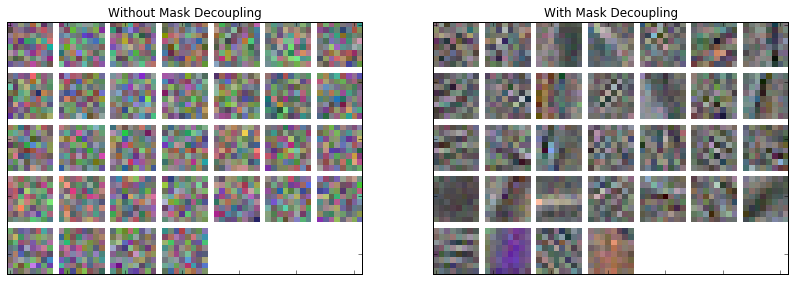

In [10]:
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(util.tiledict(D1.squeeze()), fig=fig,
            title='Without Mask Decoupling')
plot.subplot(1, 2, 2)
plot.imview(util.tiledict(D2.squeeze()), fig=fig,
            title='With Mask Decoupling')
fig.show()

Display reference and training images.

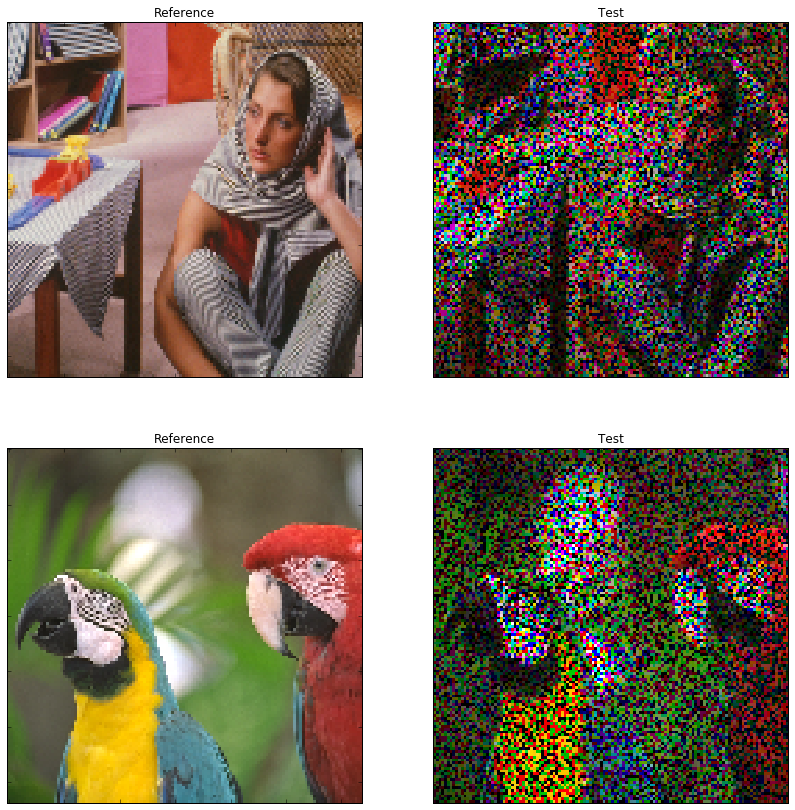

In [11]:
fig = plot.figure(figsize=(14, 14))
plot.subplot(2, 2, 1)
plot.imview(S[...,0], fig=fig, title='Reference')
plot.subplot(2, 2, 2)
plot.imview(Sw[...,0], fig=fig, title='Test')
plot.subplot(2, 2, 3)
plot.imview(S[...,1], fig=fig, title='Reference')
plot.subplot(2, 2, 4)
plot.imview(Sw[...,1], fig=fig, title='Test')
fig.show()

Compare reconstructed images.

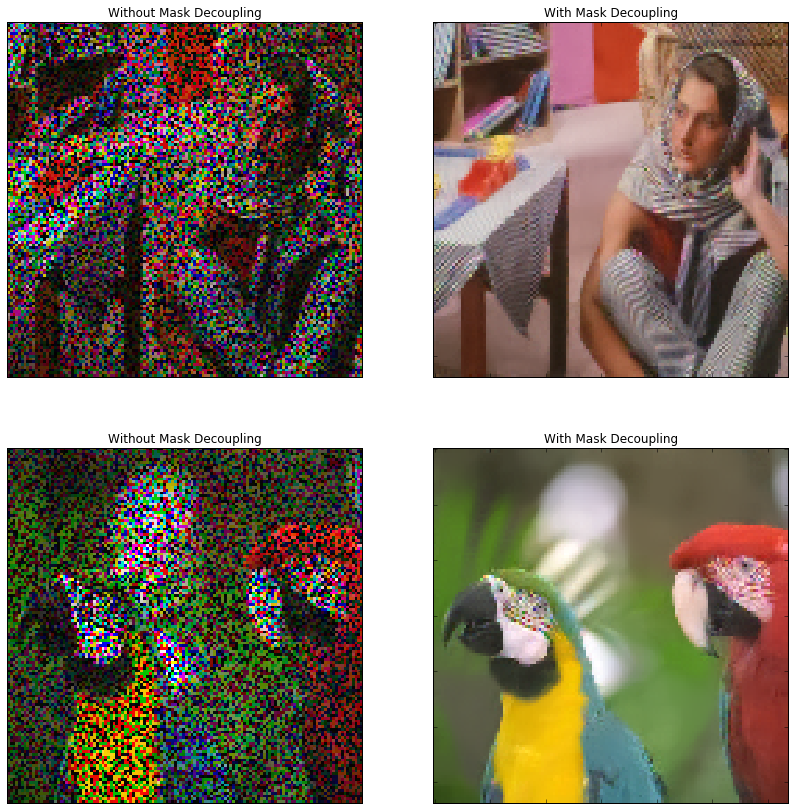

In [12]:
fig = plot.figure(figsize=(14, 14))
plot.subplot(2, 2, 1)
plot.imview(sr1[...,0], fig=fig, title='Without Mask Decoupling')
plot.subplot(2, 2, 2)
plot.imview(sr2[...,0], fig=fig, title='With Mask Decoupling')
plot.subplot(2, 2, 3)
plot.imview(sr1[...,1], fig=fig, title='Without Mask Decoupling')
plot.subplot(2, 2, 4)
plot.imview(sr2[...,1], fig=fig, title='With Mask Decoupling')
fig.show()